# Lesson 6: Overfitting and Regularization

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

pd.options.mode.chained_assignment = None

## Bias vs. Variance

See here: https://uk.wikipedia.org/wiki/Компроміс_зсуву_та_дисперсії

![bias_variance_2](https://media.geeksforgeeks.org/wp-content/uploads/20230315100857/ML--Bias-Vs-Variance-(1).png)

## Overfitting

See here: https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html

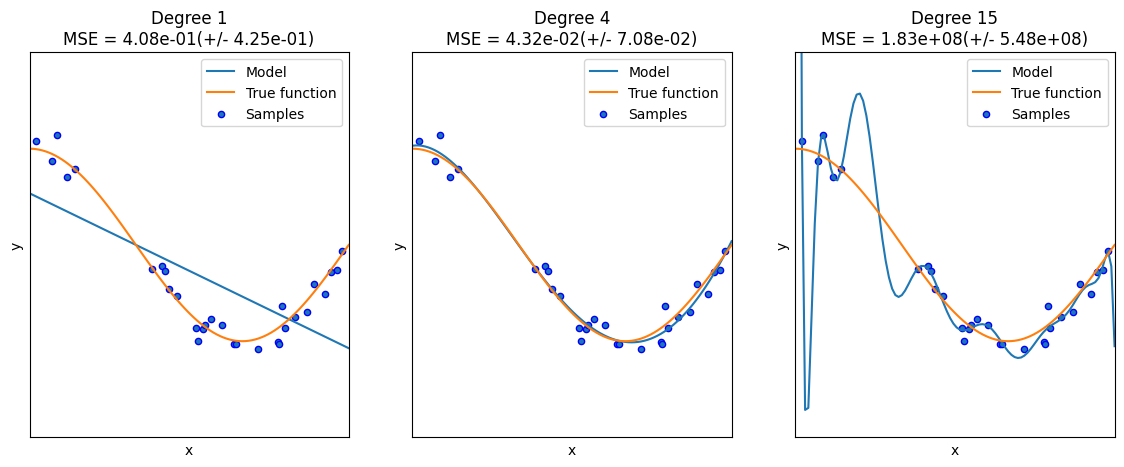

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


def true_fun(X):
    return np.cos(1.5 * np.pi * X)


np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()

### Train-test split

We will use the Kaggle Food Demand Forecasting data to demonstrate these major steps.
- Data: https://www.kaggle.com/datasets/kannanaikkal/food-demand-forecasting/

In [3]:
# Import data from Kaggle Competition
PATH = "../../data/food_demand"
df = pd.read_csv(os.path.join(PATH, "train.csv"), index_col=0)
#test_data = pd.read_csv(os.path.join(PATH, "test.csv"), index_col=0)

meal_info_df = pd.read_csv(os.path.join(PATH, "meal_info.csv"), index_col=0)
meal_info_df = meal_info_df.reset_index(drop=False)

meal_info_df[["category", "meal_id"]].groupby(["category"]).count()
df = df.merge(meal_info_df, on='meal_id', how='left')

df.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
0,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai
1,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai
2,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai
3,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian
4,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian


In [4]:
df.tail()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
456543,145,61,1543,484.09,484.09,0,0,68,Desert,Indian
456544,145,61,2304,482.09,482.09,0,0,42,Desert,Indian
456545,145,61,2664,237.68,321.07,0,0,501,Salad,Italian
456546,145,61,2569,243.50,313.34,0,0,729,Salad,Italian
456547,145,61,2490,292.03,290.03,0,0,162,Salad,Italian


In [5]:
df.cuisine.unique()

array(['Thai', 'Indian', 'Italian', 'Continental'], dtype=object)

In [6]:
df_slice = df[(df["center_id"] == 55) & (df["cuisine"] == "Thai")]
df_slice = df_slice[["checkout_price", "num_orders"]]

# sorted by checkout price
df_slice = df_slice.sort_values(by="checkout_price", axis=0, ascending=False)
df_slice.reset_index(inplace=True, drop=True)
df_slice

,checkout_price,num_orders
0,321.13,15
1,321.13,27
2,321.13,13
3,321.13,26
4,321.13,28
...,...,...
1274,80.54,54
1275,80.54,55
1276,80.54,53
1277,79.54,55


In [7]:
# train-test-split with sklearn
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_slice, shuffle=False, test_size=0.25)
train_data.head()

,checkout_price,num_orders
0,321.13,15
1,321.13,27
2,321.13,13
3,321.13,26
4,321.13,28


In [8]:
test_data.tail()

,checkout_price,num_orders
1274,80.54,54
1275,80.54,55
1276,80.54,53
1277,79.54,55
1278,79.54,53


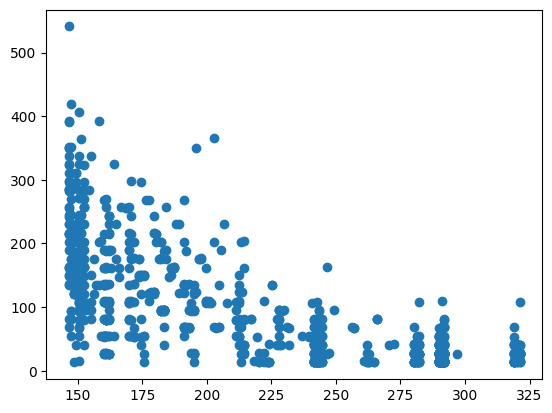

In [9]:
plt.scatter(train_data["checkout_price"], train_data["num_orders"])

In [10]:
# plt.scatter(test_data["checkout_price"], test_data["num_orders"])

In [11]:
from sklearn.linear_model import LinearRegression

x = train_data["checkout_price"].to_numpy().reshape(-1, 1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x, y)

In [12]:
train_data["predictions"] = model.predict(x)

x_test = test_data["checkout_price"].to_numpy().reshape(-1, 1)
test_data["predictions"] = model.predict(x_test)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

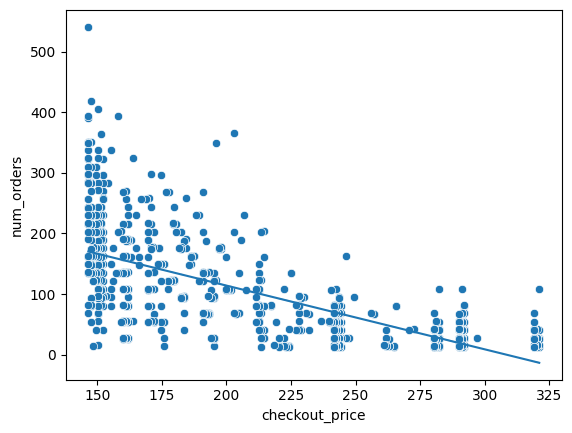

In [13]:
# Train
sns.scatterplot(x='checkout_price', y='num_orders', data=train_data)
sns.lineplot(data=train_data, x='checkout_price', y='predictions')

<Axes: xlabel='checkout_price', ylabel='num_orders'>

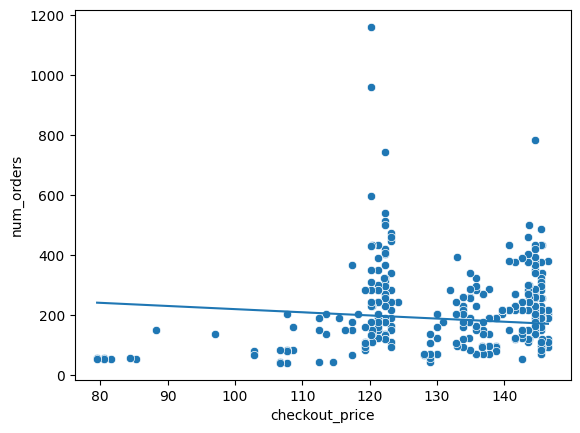

In [14]:
# Test
sns.scatterplot(x='checkout_price', y='num_orders', data=test_data)
sns.lineplot(data=test_data, x='checkout_price', y='predictions')

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error_train = mean_squared_error(train_data["num_orders"], train_data["predictions"])
print(f"Train {mean_squared_error_train=}")
mean_squared_error_test = mean_squared_error(test_data["num_orders"], test_data["predictions"])
print(f"Test {mean_squared_error_test=}")

Train mean_squared_error_train=3606.342892927836
Test mean_squared_error_test=20227.83761032738


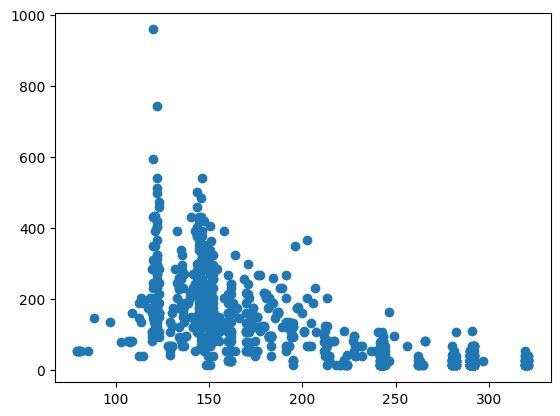

In [16]:
# Shuffle

train_data, test_data = train_test_split(df_slice, shuffle=True, test_size=0.25)

plt.scatter(train_data["checkout_price"], train_data["num_orders"])

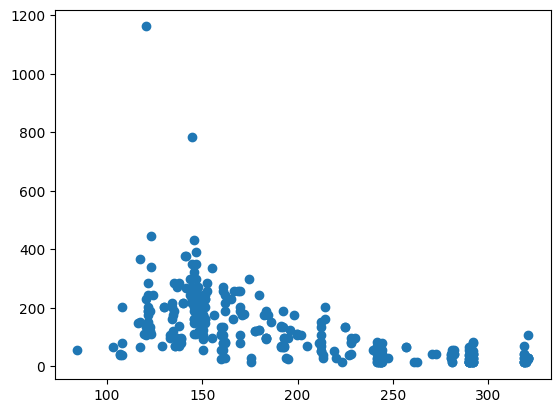

In [17]:
plt.scatter(test_data["checkout_price"], test_data["num_orders"])

In [18]:
x = train_data["checkout_price"].to_numpy().reshape(-1, 1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x, y)
train_data["predictions"] = model.predict(x)

x_test = test_data["checkout_price"].to_numpy().reshape(-1, 1)
test_data["predictions"] = model.predict(x_test)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

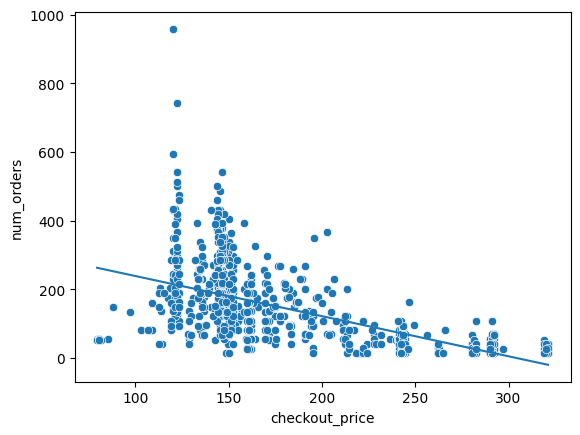

In [19]:
sns.scatterplot(x='checkout_price', y='num_orders', data=train_data)
sns.lineplot(data=train_data, x='checkout_price', y='predictions')

<Axes: xlabel='checkout_price', ylabel='num_orders'>

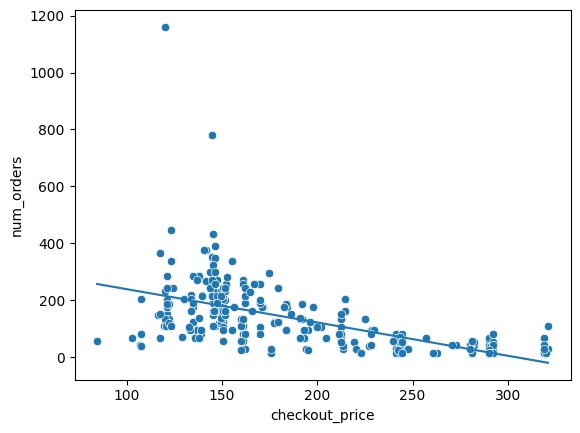

In [20]:
sns.scatterplot(x='checkout_price', y='num_orders', data=test_data)
sns.lineplot(data=test_data, x='checkout_price', y='predictions')

In [21]:
mean_squared_error_train = mean_squared_error(train_data["num_orders"], train_data["predictions"])
print(f"Train {mean_squared_error_train=}")
mean_squared_error_test = mean_squared_error(test_data["num_orders"], test_data["predictions"])
print(f"Test {mean_squared_error_test=}")

Train mean_squared_error_train=7325.844198074128
Test mean_squared_error_test=8704.742261288271


### Cross Validation

https://scikit-learn.org/stable/modules/cross_validation.html

![pic](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [22]:
from sklearn import model_selection

X = range(10)
X

range(0, 10)

In [23]:
kf = model_selection.KFold(n_splits = 5)
for train_indices, test_indices in kf.split(X):
    print(train_indices, test_indices)

[2 3 4 5 6 7 8 9] [0 1]
[0 1 4 5 6 7 8 9] [2 3]
[0 1 2 3 6 7 8 9] [4 5]
[0 1 2 3 4 5 8 9] [6 7]
[0 1 2 3 4 5 6 7] [8 9]


In [24]:
kf = model_selection.KFold(n_splits = 2, shuffle = True)
for train_indices, test_indices in kf.split(X):
    print(train_indices, test_indices)

[0 1 3 5 8] [2 4 6 7 9]
[2 4 6 7 9] [0 1 3 5 8]


In [25]:
kf = model_selection.KFold(n_splits = 2, shuffle = True, random_state = 1)
for train_indices, test_indices in kf.split(X):
    print(train_indices, test_indices)

[1 3 5 7 8] [0 2 4 6 9]
[0 2 4 6 9] [1 3 5 7 8]


In [26]:
X = range(12)

In [27]:
y = np.array([0] * 6 + [1] * 6)
print(y)

skf = model_selection.StratifiedKFold(n_splits = 2, shuffle = True, random_state = 0)
for train_indices, test_indices in skf.split(X, y):
    print(train_indices, test_indices)

[0 0 0 0 0 0 1 1 1 1 1 1]
[ 0  3  5  7  8 11] [ 1  2  4  6  9 10]
[ 1  2  4  6  9 10] [ 0  3  5  7  8 11]


In [29]:
y = np.array([0, 1] * 6)
print(y)

skf = model_selection.StratifiedKFold(n_splits = 2, shuffle = True, random_state = 0)
for train_indices, test_indices in skf.split(X, y):
    print(train_indices, test_indices)

[0 1 0 1 0 1 0 1 0 1 0 1]
[ 0  3  5  6 10 11] [1 2 4 7 8 9]
[1 2 4 7 8 9] [ 0  3  5  6 10 11]


In [30]:
ss = model_selection.ShuffleSplit(n_splits = 10, test_size = 0.2)

for train_indices, test_indices in ss.split(X):
    print(train_indices, test_indices)

[ 6  5  8 11  4  1  0  7 10] [3 9 2]
[ 3 11  6  2  8  9  4  5 10] [0 1 7]
[ 6  7  5 10  1  9  8  0  3] [ 2  4 11]
[ 6 11 10  0  4  5  9  3  2] [7 8 1]
[ 5  7  6 10  0 11  4  1  8] [2 3 9]
[ 4  7  8  5  6 10  3  0  9] [ 2 11  1]
[ 9  0 10  3  1  2 11  5  8] [4 6 7]
[ 4  0  9  1 11  7  2  6  8] [ 3  5 10]
[ 8  4  9  0  1  2 11  3 10] [5 7 6]
[ 9  4 10  8  7  1 11  2  3] [0 6 5]


In [31]:
X = range(10)
target = np.array([0] * 5 + [1] * 5)
print(target)

sss = model_selection.StratifiedShuffleSplit(n_splits = 4, test_size = 0.2)
for train_indices, test_indices in sss.split(X, target):
    print(train_indices, test_indices)

[0 0 0 0 0 1 1 1 1 1]
[2 5 4 1 6 7 9 3] [8 0]
[4 6 8 7 5 2 0 3] [9 1]
[7 8 4 6 0 1 3 9] [2 5]
[9 4 0 2 6 7 8 1] [5 3]


In [32]:
loo = model_selection.LeaveOneOut()

for train_indices, test_index in loo.split(X):
    print(train_indices, test_index)

[1 2 3 4 5 6 7 8 9] [0]
[0 2 3 4 5 6 7 8 9] [1]
[0 1 3 4 5 6 7 8 9] [2]
[0 1 2 4 5 6 7 8 9] [3]
[0 1 2 3 5 6 7 8 9] [4]
[0 1 2 3 4 6 7 8 9] [5]
[0 1 2 3 4 5 7 8 9] [6]
[0 1 2 3 4 5 6 8 9] [7]
[0 1 2 3 4 5 6 7 9] [8]
[0 1 2 3 4 5 6 7 8] [9]


## Regularization

Ridge Regression : In ridge regression, the cost function is altered by adding a penalty equivalent to square of the magnitude of the coefficients.

Classic linear regression:
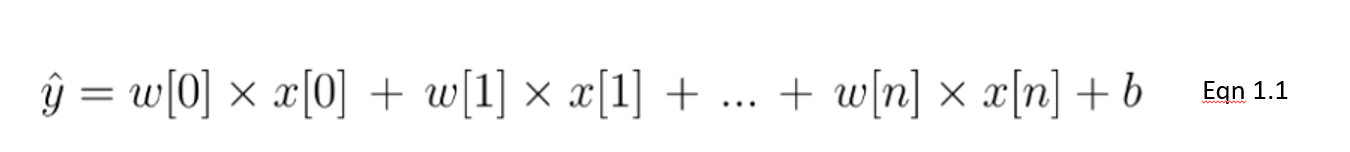

Sum of squares in classic linear regression:
![normal_cost_function](https://images.datacamp.com/image/upload/v1648205671/image14_elbrgp.png)

### Lasso (L1)

![image.png](https://images.datacamp.com/image/upload/v1648205671/image17_ryqgum.png)

### Ridge (L2)
![image](https://miro.medium.com/v2/resize:fit:1126/format:webp/1*7WR8ORB7cHNOJYZRBU5a1Q.png)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

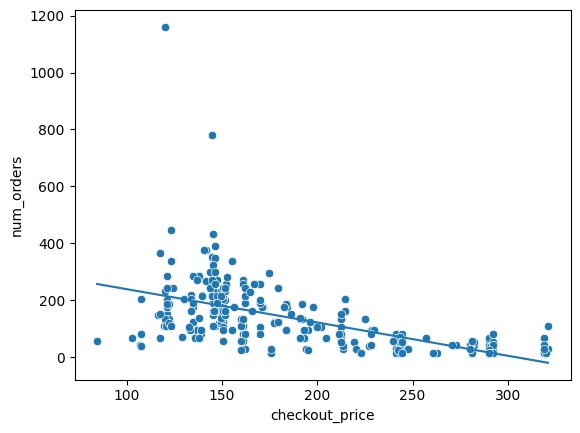

In [33]:
x = train_data["checkout_price"].to_numpy().reshape(-1, 1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x, y)
train_data["predictions"] = model.predict(x)

x_test = test_data["checkout_price"].to_numpy().reshape(-1, 1)
test_data["predictions"] = model.predict(x_test)

sns.scatterplot(x='checkout_price', y='num_orders', data=test_data)
sns.lineplot(data=test_data, x='checkout_price', y='predictions')

In [34]:
mean_squared_error_test = mean_squared_error(test_data["num_orders"], test_data["predictions"])
print(f"Train {mean_squared_error_test=}")

Train mean_squared_error_test=8704.742261288271


In [35]:
model.coef_

array([-1.16981158])

In [36]:
from copy import deepcopy
coefs = [-2.0, -1.7, -1.4, -1.16981158, -0.99, -0.98, -0.97, -0.84, -0.64, -0.5, -0.2, 0.01, 0.2, 0.45, 0.76, 0.99, 1.2]

models = []
for coef in coefs:
    new_model = deepcopy(model)
    new_model.coef_ = np.array([coef])
    models.append(new_model)

for i in range(len(models)):    
    test_data[f"exp_{i}"] = models[i].predict(x_test)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

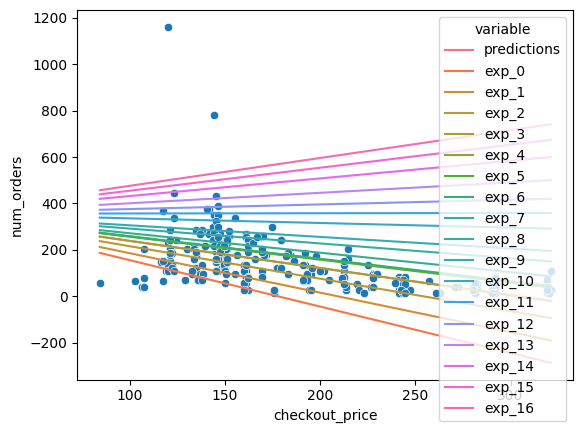

In [37]:
sns.scatterplot(x='checkout_price', y='num_orders', data=test_data)
sns.lineplot(x='checkout_price', y='value', hue="variable", data=pd.melt(test_data.drop(["num_orders"], axis=1), ['checkout_price']))

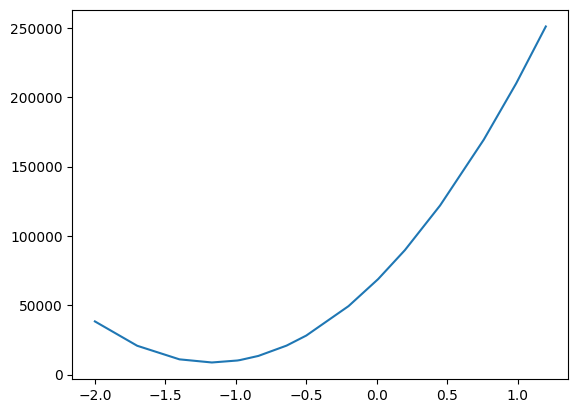

In [38]:
losses = []
for i, model in enumerate(models):
    losses.append(mean_squared_error(test_data["num_orders"], test_data[f"exp_{i}"]))

plt.plot(np.array(coefs), np.array(losses), label='MSE')

<Axes: xlabel='checkout_price', ylabel='num_orders'>

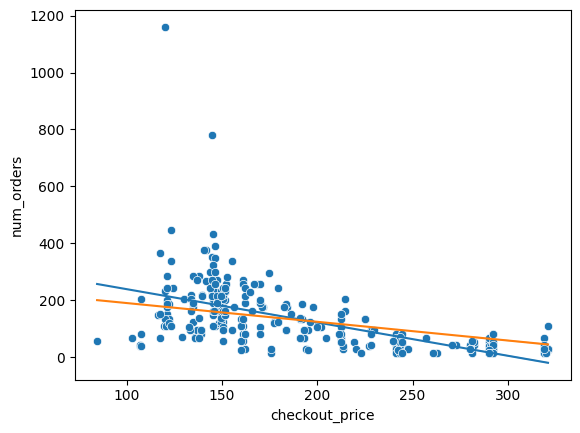

In [39]:
from sklearn.linear_model import Ridge, Lasso

model_lasso = Lasso(alpha=2000.0).fit(x, y)

test_data_lasso = test_data[:]

x_test = test_data_lasso["checkout_price"].to_numpy().reshape(-1, 1)
test_data_lasso["predictions"] = model_lasso.predict(x_test)

sns.scatterplot(x='checkout_price', y='num_orders', data=test_data_lasso)
sns.lineplot(data=test_data, x='checkout_price', y='predictions')
sns.lineplot(data=test_data_lasso, x='checkout_price', y='predictions')

In [40]:
mean_squared_error_test_lasso = mean_squared_error(test_data_lasso["num_orders"], test_data_lasso["predictions"])
print(f"Train {mean_squared_error_test_lasso=}")

Train mean_squared_error_test_lasso=9356.596585890697


In [41]:
model_lasso.coef_

array([-0.65809712])

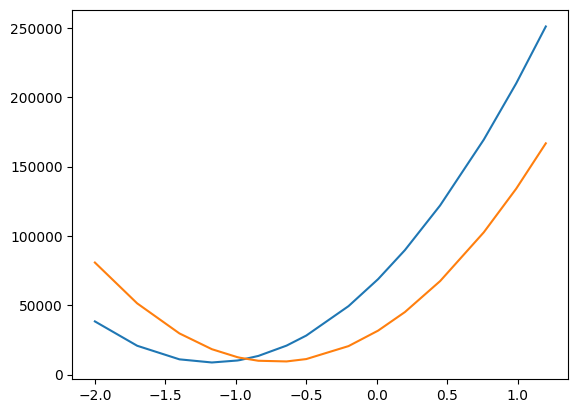

In [42]:
coefs = [-2.0, -1.7, -1.4, -1.16981158, -0.99, -0.98, -0.97, -0.84, -0.64, -0.5, -0.2, 0.01, 0.2, 0.45, 0.76, 0.99, 1.2]

models_lasso = []
for coef in coefs:
    new_model = deepcopy(model_lasso)
    new_model.coef_ = np.array([coef])
    models_lasso.append(new_model)

for i in range(len(models_lasso)):    
    test_data_lasso[f"exp_{i}"] = models_lasso[i].predict(x_test)

losses_lasso = []
for i, model in enumerate(models_lasso):
    losses_lasso.append(mean_squared_error(test_data_lasso["num_orders"], test_data_lasso[f"exp_{i}"]))

plt.plot(np.array(coefs), np.array(losses), label='MSE')
plt.plot(np.array(coefs), np.array(losses_lasso), label='MSE')

/Users/nataliakees/miniconda3/envs/python_data_env/lib/python3.11/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/nataliakees/miniconda3/envs/python_data_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/nataliakees/miniconda3/envs/python_data_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.513e+06, tolerance: 1.215e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

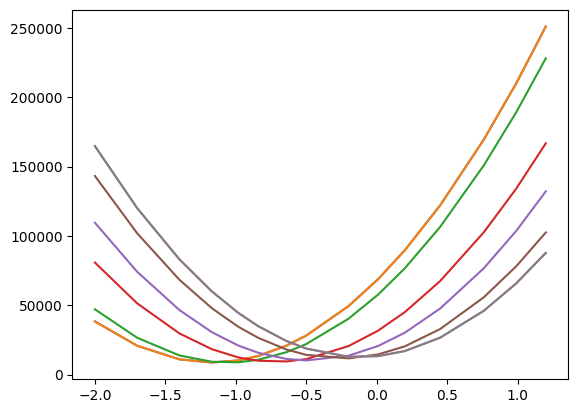

In [43]:
plt.plot(np.array(coefs), np.array(losses), label='MSE')

losses_lasso_all = [losses]

for i in [0, 500, 2000, 3000, 4000, 5000, 10000]:
    model_lasso = Lasso(alpha=i).fit(x, y)
    
    x_test = test_data_lasso["checkout_price"].to_numpy().reshape(-1, 1)
    test_data_lasso["predictions"] = model_lasso.predict(x_test)
    models_lasso = []
    for coef in coefs:
        new_model = deepcopy(model_lasso)
        new_model.coef_ = np.array([coef])
        models_lasso.append(new_model)
    
    for i in range(len(models_lasso)):    
        test_data_lasso[f"exp_{i}"] = models_lasso[i].predict(x_test)
    
    losses_lasso = []
    for i, model in enumerate(models_lasso):
        losses_lasso.append(mean_squared_error(test_data_lasso["num_orders"], test_data_lasso[f"exp_{i}"]))
    
    losses_lasso_all.append(losses_lasso)
    plt.plot(np.array(coefs), np.array(losses_lasso), label='MSE')


In [44]:
losses_lasso_all

[[38333.99186776549,
  20769.939507879597,
  10965.900807768709,
  8704.742260951858,
  10116.714452953287,
  10277.069576035465,
  10446.046936517394,
  13427.376226159718,
  20859.375013680787,
  28113.86666608604,
  49349.88260507515,
  68832.30188993365,
  89735.7028833773,
  121982.40844461301,
  169452.42540352832,
  210026.52483054894,
  251055.91537738265],
 [38333.99186776547,
  20769.939507879586,
  10965.900807768703,
  8704.74226095186,
  10116.71445295329,
  10277.06957603547,
  10446.046936517398,
  13427.376226159724,
  20859.3750136808,
  28113.866666086054,
  49349.88260507517,
  68832.30188993367,
  89735.70288337732,
  121982.40844461303,
  169452.42540352835,
  210026.52483054894,
  251055.9153773827],
 [47075.866615923165,
  26541.24522481163,
  13766.637493475111,
  9226.17697399573,
  8857.673462651324,
  8919.009618025982,
  8988.96801080039,
  10683.050720244937,
  16134.670153615589,
  22002.896258115543,
  40268.34316587902,
  57671.36412887958,
  76693.40473

In [ ]:
8704.742260951858

Train mean_squared_error_test_ridge=8704.30405753539


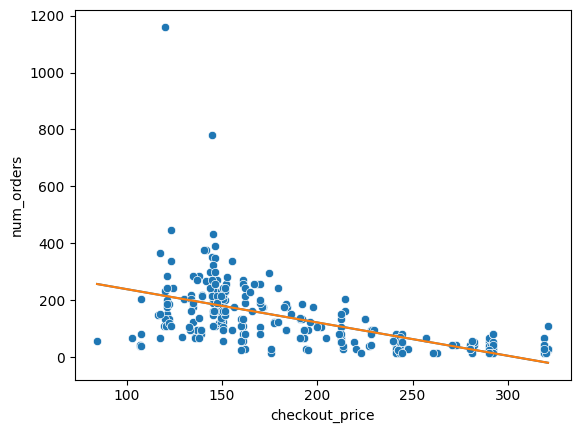

In [45]:
model_ridge = Ridge(alpha=2000.0).fit(x, y)

test_data_ridge = test_data[:]

x_test = test_data_ridge["checkout_price"].to_numpy().reshape(-1, 1)
test_data_ridge["predictions"] = model_ridge.predict(x_test)

sns.scatterplot(x='checkout_price', y='num_orders', data=test_data_ridge)
sns.lineplot(data=test_data, x='checkout_price', y='predictions')
sns.lineplot(data=test_data_ridge, x='checkout_price', y='predictions')

mean_squared_error_test_ridge = mean_squared_error(test_data_ridge["num_orders"], test_data_ridge["predictions"])
print(f"Test {mean_squared_error_test_ridge=}")

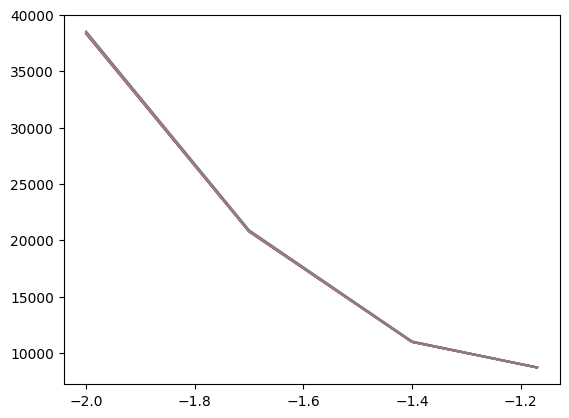

In [47]:
plt.plot(np.array(coefs[:4]), np.array(losses[:4]), label='MSE')
coefs = [-2.0, -1.7, -1.4, -1.16981158, -0.99, -0.98, -0.97, -0.84, -0.64, -0.5, -0.2, 0.01, 0.2, 0.45, 0.76, 0.99, 1.2]

losses_ridge_all = [losses]

for i in [0, 500, 2000, 3000, 4000, 5000, 10000]:
    model_ridge = Ridge(alpha=i).fit(x, y)
    
    x_test = test_data_ridge["checkout_price"].to_numpy().reshape(-1, 1)
    test_data_ridge["predictions"] = model_ridge.predict(x_test)
    models_ridge = []
    for coef in coefs:
        new_model = deepcopy(model_ridge)
        new_model.coef_ = np.array([coef])
        models_ridge.append(new_model)
    
    for i in range(len(models_ridge)):    
        test_data_ridge[f"exp_{i}"] = models_ridge[i].predict(x_test)
    
    losses_ridge = []
    for i, model in enumerate(models_ridge):
        losses_ridge.append(mean_squared_error(test_data_ridge["num_orders"], test_data_ridge[f"exp_{i}"]))
    
    losses_ridge_all.append(losses_ridge)
    plt.plot(np.array(coefs[:4]), np.array(losses_ridge[:4]), label='MSE')
# ridge regularization can improve the test mse by reducing the bias term

In [48]:
losses_ridge_all

[[38333.99186776549,
  20769.939507879597,
  10965.900807768709,
  8704.742260951858,
  10116.714452953287,
  10277.069576035465,
  10446.046936517394,
  13427.376226159718,
  20859.375013680787,
  28113.86666608604,
  49349.88260507515,
  68832.30188993365,
  89735.7028833773,
  121982.40844461301,
  169452.42540352832,
  210026.52483054894,
  251055.91537738265],
 [38333.99186776545,
  20769.93950787957,
  10965.900807768698,
  8704.74226095186,
  10116.714452953294,
  10277.069576035476,
  10446.046936517403,
  13427.376226159733,
  20859.375013680816,
  28113.866666086076,
  49349.88260507519,
  68832.30188993372,
  89735.70288337737,
  121982.40844461307,
  169452.42540352838,
  210026.52483054902,
  251055.91537738274],
 [38343.893281639845,
  20776.21783255146,
  10968.556043238079,
  8704.61751915776,
  10114.418133179252,
  10274.652486621346,
  10443.509077463192,
  13423.268361784436,
  20852.851756503846,
  28105.65263394794,
  49338.04548373455,
  68817.9286061513,
  89719

In [ ]:
8704.742260951858

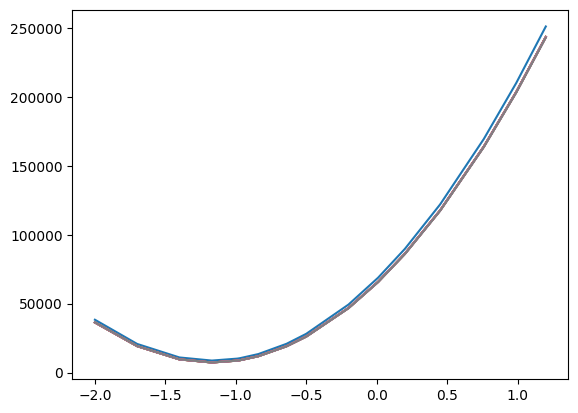

In [49]:
plt.plot(np.array(coefs), np.array(losses), label='MSE')

losses_ridge_all = [losses]
train_data_ridge = train_data[:]
for i in [0, 500, 2000, 3000, 4000, 5000, 10000]:
    model_ridge = Ridge(alpha=i).fit(x, y)
    
    train_data_ridge["predictions"] = model_ridge.predict(x)
    models_ridge = []
    for coef in coefs:
        new_model = deepcopy(model_ridge)
        new_model.coef_ = np.array([coef])
        models_ridge.append(new_model)
    
    for i in range(len(models_ridge)):    
        train_data_ridge[f"exp_{i}"] = models_ridge[i].predict(x)
    
    losses_ridge = []
    for i, model in enumerate(models_ridge):
        losses_ridge.append(mean_squared_error(train_data_ridge["num_orders"], train_data_ridge[f"exp_{i}"]))
    
    losses_ridge_all.append(losses_ridge)
    plt.plot(np.array(coefs), np.array(losses_ridge), label='MSE')

## Hyperparameter tuning

Examples

- Параметр регуляризації λ
- Ступінь полінома в задачі регресії з сімейством алгоритмів, заданим безліччю поліномів деякого ступеня
- learning rate
- ...

![image](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/61568656a13218cdde7f6166_training-data-validation-test.png)

In [51]:
from sklearn.model_selection import cross_val_score, cross_validate, ShuffleSplit
m = LinearRegression()
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(m, x, y, cv=cv)
scores, np.mean(scores)

(array([0.45494326, 0.408713  , 0.41555767, 0.42133693, 0.4214789 ]),
 0.4244059517057261)

In [52]:
m = Ridge(3000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores)

(array([0.34138429, 0.50262371, 0.42417748, 0.3938907 , 0.4366604 ]),
 0.41974731502907925)

In [53]:
m = Ridge(5000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores)

(array([0.34138263, 0.50261135, 0.42432223, 0.3938243 , 0.43666275]),
 0.4197606529533323)

In [54]:
m = Lasso(2000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores)

(array([0.27754222, 0.3947668 , 0.39735264, 0.28983665, 0.34947405]),
 0.34179447189917145)

In [55]:
m = Lasso(4000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores)

(array([0.08741641, 0.08624695, 0.13174648, 0.06660693, 0.0837503 ]),
 0.09115341362599469)

In [60]:
m = LinearRegression().fit(x, y)
x_test = test_data["checkout_price"].to_numpy().reshape(-1, 1)
y_test = test_data["num_orders"].to_numpy()
pred = m.predict(x_test)
sklearn.metrics.r2_score(y_test, pred)

0.3377135997244054